In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_04_09_22
NN-MODEL FILENAME:  ./models/VBKG0BIX_04_09_22_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 6
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  6


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 71564.21 MiB, increment: 65563.01 MiB
Quantization TIME:  0.59 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   40583
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 177
TOTAL SERIAL TIMESTEPS:   40583
TOTAL PARALLEL TIMESTEPS: 177


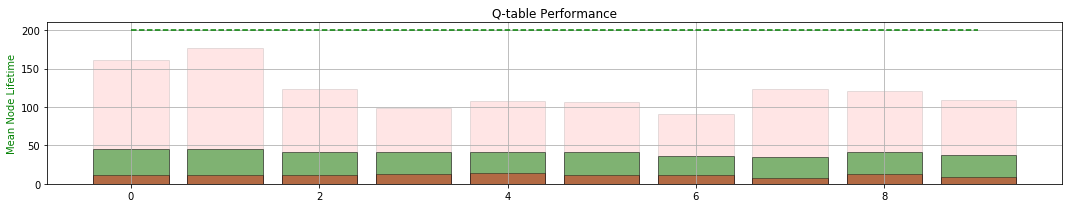

MEMORY COUNTER:  40583
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 227.172	LOSS : 229.800	LOSS : 228.967	LOSS : 240.777	LOSS : 236.923	LOSS : 233.607	LOSS : 216.818	LOSS : 215.867	LOSS : 217.167	LOSS : 219.582	LOSS : 224.134	LOSS : 220.164	LOSS : 202.803	LOSS : 228.473	LOSS : 229.436	LOSS : 214.693	LOSS : 215.395	LOSS : 230.831	LOSS : 208.541	LOSS : 212.344	
Validating... MEAN TIME:  200.0
LOSS : 207.823	LOSS : 207.509	LOSS : 204.968	LOSS : 211.483	LOSS : 214.994	LOSS : 204.809	LOSS : 215.007	LOSS : 209.393	LOSS : 213.631	LOSS : 218.803	LOSS : 210.704	LOSS : 213.616	LOSS : 208.934	LOSS : 203.943	LOSS : 205.645	LOSS : 209.982	LOSS : 219.167	LOSS : 215.870	LOSS : 212.457	LOSS : 198.641	
Validating... MEAN TIME:  197.845
LOSS : 204.925	LOSS : 197.319	LOSS : 200.473	LOSS : 212.743	LOSS : 216.226	LOSS : 206.399	LOSS : 197.636	LOSS : 208.660	LOSS : 197.102	LOSS : 202.792	LOSS : 209.379	LOSS : 205.755	LOSS : 209.727	LOSS : 217.228	LOSS : 201.473	LOSS : 210.904	LOSS : 202

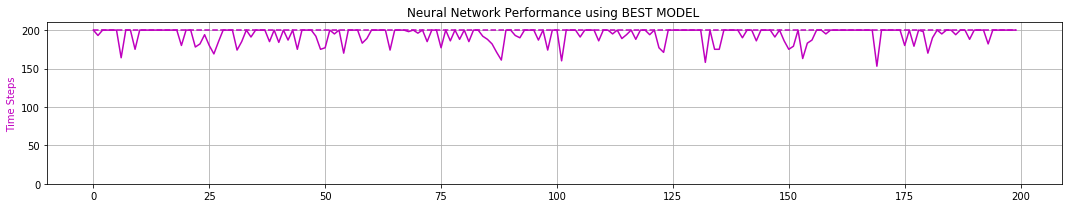

peak memory: 72235.16 MiB, increment: 65019.87 MiB
0 -max- [ 1.469  2.599  0.208  2.032  0.474]
0 -min- [-0.457 -1.218 -0.209 -2.005  0.426]

1 -max- [ 0.895  2.104  0.207  2.037  0.524]
1 -min- [-1.216 -1.547 -0.209 -2.085  0.476]

2 -max- [ 1.419  2.473  0.209  1.622  0.574]
2 -min- [-0.444 -1.321 -0.209 -2.127  0.525]

3 -max- [ 1.620  3.144  0.209  1.700  0.624]
3 -min- [-0.514 -1.195 -0.209 -2.060  0.575]

4 -max- [ 1.132  2.416  0.209  1.709  0.675]
4 -min- [-0.552 -1.190 -0.209 -2.249  0.626]

5 -max- [ 1.239  2.461  0.207  1.618  0.725]
5 -min- [-0.356 -1.263 -0.209 -2.466  0.676]

6 -max- [ 1.333  3.363  0.207  1.763  0.775]
6 -min- [-0.510 -1.165 -0.209 -2.808  0.725]

7 -max- [ 1.306  2.407  0.208  2.099  0.825]
7 -min- [-0.437 -1.404 -0.209 -2.194  0.776]

8 -max- [ 1.530  3.224  0.208  2.160  0.874]
8 -min- [-0.923 -1.518 -0.209 -2.313  0.825]

9 -max- [ 1.173  1.890  0.208  2.253  0.925]
9 -min- [-0.215 -1.200 -0.209 -2.247  0.875]

Quantization TIME:  0.58 minutes


ITER

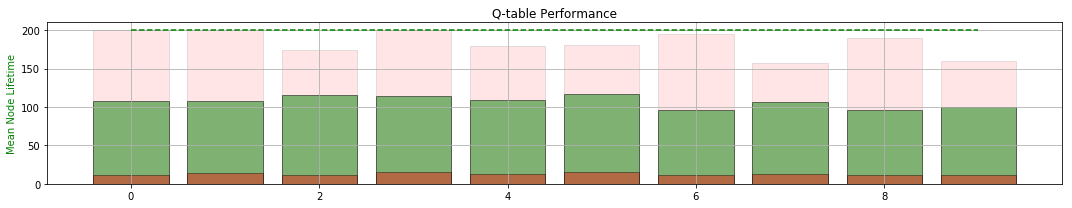

MEMORY COUNTER:  147387
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 118.321	LOSS : 120.532	LOSS : 117.322	LOSS : 130.100	LOSS : 118.342	LOSS : 127.020	LOSS : 129.345	LOSS : 121.531	LOSS : 122.065	LOSS : 124.125	LOSS : 121.746	LOSS : 118.548	LOSS : 122.471	LOSS : 122.158	LOSS : 131.299	LOSS : 137.539	LOSS : 121.533	LOSS : 126.251	LOSS : 125.643	LOSS : 115.303	
Validating... MEAN TIME:  139.335
LOSS : 120.160	LOSS : 130.870	LOSS : 113.313	LOSS : 118.117	LOSS : 115.835	LOSS : 115.001	LOSS : 117.402	LOSS : 121.947	LOSS : 122.422	LOSS : 116.584	LOSS : 111.778	LOSS : 113.893	LOSS : 121.419	LOSS : 118.927	LOSS : 111.164	LOSS : 113.383	LOSS : 122.804	LOSS : 118.603	LOSS : 125.185	LOSS : 113.989	
Validating... MEAN TIME:  159.75
LOSS : 127.232	LOSS : 115.722	LOSS : 115.392	LOSS : 106.982	LOSS : 116.661	LOSS : 117.718	LOSS : 122.625	LOSS : 122.137	LOSS : 118.446	LOSS : 117.232	LOSS : 121.832	LOSS : 110.391	LOSS : 124.870	LOSS : 125.615	LOSS : 119.815	LOSS : 130.481	LOSS : 1

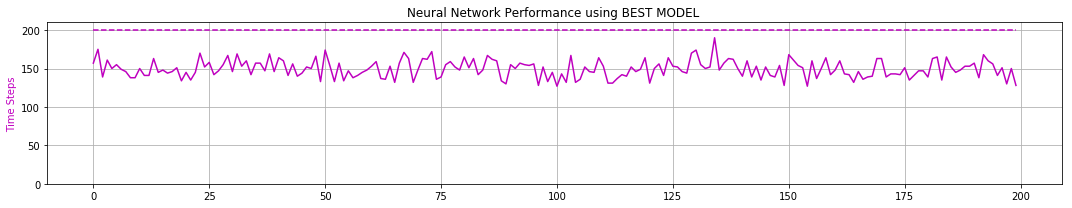

peak memory: 73514.55 MiB, increment: 65093.75 MiB
0 -max- [ 0.278  1.215  0.208  2.373  0.475]
0 -min- [-2.399 -3.160 -0.209 -1.921  0.425]

1 -max- [ 0.246  1.535  0.203  1.995  0.525]
1 -min- [-2.399 -2.790 -0.209 -1.903  0.475]

2 -max- [ 0.157  1.210  0.199  1.959  0.575]
2 -min- [-2.399 -2.780 -0.209 -2.244  0.526]

3 -max- [ 0.417  1.492  0.209  1.950  0.625]
3 -min- [-2.399 -2.779 -0.209 -2.200  0.575]

4 -max- [ 0.230  1.301  0.202  2.679  0.675]
4 -min- [-2.399 -2.933 -0.207 -1.843  0.625]

5 -max- [ 0.208  1.115  0.208  1.850  0.725]
5 -min- [-2.396 -2.933 -0.209 -2.134  0.675]

6 -max- [ 0.255  1.027  0.203  1.863  0.775]
6 -min- [-2.399 -2.914 -0.209 -1.994  0.726]

7 -max- [ 0.172  1.009  0.194  1.974  0.824]
7 -min- [-2.398 -2.911 -0.209 -1.983  0.776]

8 -max- [ 0.248  1.210  0.205  1.562  0.875]
8 -min- [-2.398 -3.156 -0.209 -1.794  0.825]

9 -max- [ 0.247  1.375  0.200  1.646  0.925]
9 -min- [-2.399 -2.956 -0.209 -2.318  0.875]

Quantization TIME:  0.58 minutes


ITER

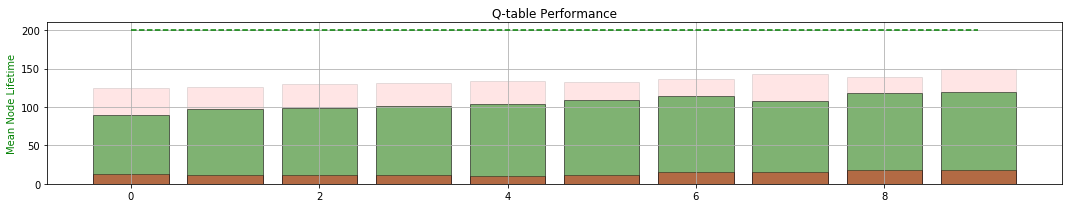

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 103.505	LOSS : 99.960	LOSS : 88.686	LOSS : 94.354	LOSS : 82.603	LOSS : 79.686	LOSS : 89.886	LOSS : 97.882	LOSS : 88.794	LOSS : 90.880	LOSS : 92.308	LOSS : 92.087	LOSS : 85.295	LOSS : 93.637	LOSS : 88.255	LOSS : 85.091	LOSS : 79.799	LOSS : 90.415	LOSS : 94.102	LOSS : 92.224	
Validating... MEAN TIME:  131.575
LOSS : 82.807	LOSS : 91.472	LOSS : 93.727	LOSS : 80.162	LOSS : 89.236	LOSS : 90.579	LOSS : 81.526	LOSS : 81.131	LOSS : 100.661	LOSS : 95.992	LOSS : 95.319	LOSS : 92.207	LOSS : 83.383	LOSS : 93.716	LOSS : 86.195	LOSS : 85.092	LOSS : 98.196	LOSS : 93.776	LOSS : 88.140	LOSS : 77.569	
Validating... MEAN TIME:  122.68
LOSS : 88.917	LOSS : 89.078	LOSS : 86.629	LOSS : 77.311	LOSS : 88.042	LOSS : 91.806	LOSS : 88.223	LOSS : 93.757	LOSS : 85.671	LOSS : 91.458	LOSS : 91.961	LOSS : 83.600	LOSS : 85.548	LOSS : 101.516	LOSS : 95.919	LOSS : 90.611	LOSS : 78.868	LOSS : 85.052	LOSS : 81.922	LOSS : 80.927	
Vali

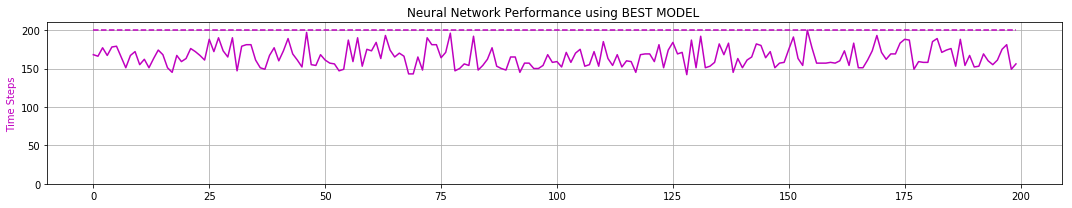

peak memory: 73929.58 MiB, increment: 65482.66 MiB
0 -max- [ 0.185  0.980  0.052  1.167  0.475]
0 -min- [-2.400 -2.931 -0.209 -1.526  0.425]

1 -max- [ 0.199  1.361  0.053  1.352  0.524]
1 -min- [-2.400 -2.995 -0.209 -2.022  0.476]

2 -max- [ 0.184  1.194  0.063  1.272  0.573]
2 -min- [-2.400 -2.930 -0.209 -1.996  0.525]

3 -max- [ 0.193  1.005  0.048  1.145  0.625]
3 -min- [-2.400 -2.806 -0.209 -1.509  0.575]

4 -max- [ 0.190  1.031  0.048  1.170  0.675]
4 -min- [-2.398 -2.790 -0.209 -1.720  0.626]

5 -max- [ 0.204  1.025  0.122  1.752  0.725]
5 -min- [-2.398 -3.133 -0.209 -1.620  0.677]

6 -max- [ 0.163  0.824  0.067  1.473  0.773]
6 -min- [-2.400 -2.988 -0.209 -1.431  0.725]

7 -max- [ 0.189  0.961  0.075  1.242  0.825]
7 -min- [-2.400 -2.920 -0.209 -1.479  0.775]

8 -max- [ 0.168  0.976  0.085  1.287  0.875]
8 -min- [-2.399 -2.992 -0.207 -1.418  0.825]

9 -max- [ 0.183  0.945  0.106  1.830  0.925]
9 -min- [-2.400 -2.797 -0.209 -1.493  0.875]

Quantization TIME:  0.58 minutes


ITER

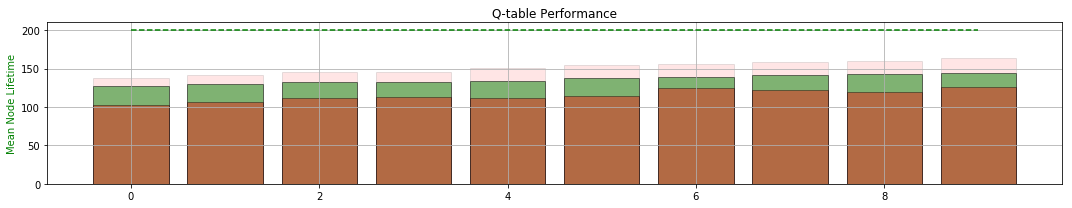

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 86.189	LOSS : 78.325	LOSS : 82.661	LOSS : 83.514	LOSS : 80.729	LOSS : 80.668	LOSS : 64.016	LOSS : 76.252	LOSS : 76.165	LOSS : 80.581	LOSS : 70.146	LOSS : 79.701	LOSS : 79.949	LOSS : 78.584	LOSS : 79.596	LOSS : 89.049	LOSS : 74.083	LOSS : 75.187	LOSS : 69.777	LOSS : 75.892	
Validating... MEAN TIME:  161.385
LOSS : 66.045	LOSS : 77.505	LOSS : 68.611	LOSS : 77.531	LOSS : 70.932	LOSS : 71.406	LOSS : 69.411	LOSS : 76.703	LOSS : 74.244	LOSS : 71.879	LOSS : 74.353	LOSS : 69.887	LOSS : 67.917	LOSS : 79.830	LOSS : 82.832	LOSS : 71.797	LOSS : 72.827	LOSS : 88.012	LOSS : 77.633	LOSS : 74.894	
Validating... MEAN TIME:  131.025
LOSS : 73.968	LOSS : 69.407	LOSS : 78.471	LOSS : 75.221	LOSS : 70.904	LOSS : 73.513	LOSS : 69.485	LOSS : 74.234	LOSS : 71.057	LOSS : 74.061	LOSS : 77.745	LOSS : 77.403	LOSS : 75.842	LOSS : 75.321	LOSS : 79.965	LOSS : 67.309	LOSS : 73.202	LOSS : 77.891	LOSS : 74.246	LOSS : 72.516	
Valida

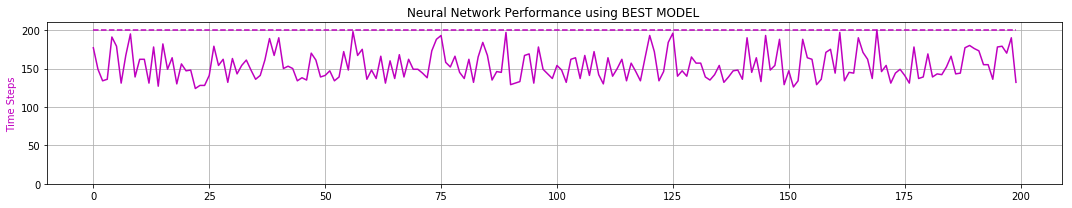

peak memory: 73942.54 MiB, increment: 65480.50 MiB
0 -max- [ 0.141  1.001  0.050  1.078  0.475]
0 -min- [-2.400 -2.778 -0.209 -1.528  0.425]

1 -max- [ 0.178  1.167  0.047  0.932  0.525]
1 -min- [-2.398 -2.799 -0.207 -1.667  0.476]

2 -max- [ 0.188  1.008  0.048  0.935  0.575]
2 -min- [-2.400 -2.778 -0.208 -1.456  0.525]

3 -max- [ 0.149  1.015  0.048  0.945  0.624]
3 -min- [-2.400 -2.734 -0.209 -1.447  0.575]

4 -max- [ 0.140  0.928  0.046  0.925  0.675]
4 -min- [-2.400 -2.744 -0.209 -1.459  0.625]

5 -max- [ 0.138  0.823  0.050  0.778  0.723]
5 -min- [-2.399 -2.617 -0.209 -1.387  0.675]

6 -max- [ 0.130  0.829  0.049  1.017  0.775]
6 -min- [-2.400 -2.619 -0.209 -1.383  0.727]

7 -max- [ 0.126  0.925  0.049  1.012  0.825]
7 -min- [-2.400 -2.610 -0.209 -1.408  0.775]

8 -max- [ 0.146  1.009  0.049  0.871  0.874]
8 -min- [-2.400 -2.609 -0.209 -1.474  0.825]

9 -max- [ 0.157  1.015  0.055  0.910  0.924]
9 -min- [-2.400 -2.615 -0.209 -1.409  0.876]

Quantization TIME:  0.59 minutes


ITER

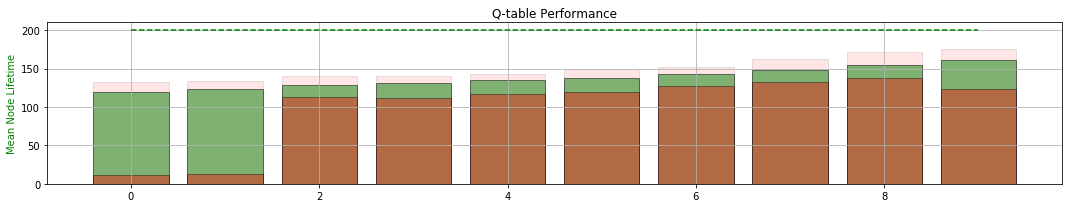

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 60.032	LOSS : 64.707	LOSS : 61.602	LOSS : 64.494	LOSS : 57.659	LOSS : 64.654	LOSS : 67.103	LOSS : 72.660	LOSS : 64.667	LOSS : 66.115	LOSS : 57.067	LOSS : 57.111	LOSS : 71.150	LOSS : 63.725	LOSS : 62.229	LOSS : 61.362	LOSS : 59.929	LOSS : 58.876	LOSS : 68.591	LOSS : 56.856	
Validating... MEAN TIME:  116.3
LOSS : 65.012	LOSS : 62.454	LOSS : 63.534	LOSS : 71.737	LOSS : 60.049	LOSS : 60.987	LOSS : 59.153	LOSS : 61.223	LOSS : 67.480	LOSS : 64.832	LOSS : 62.806	LOSS : 67.631	LOSS : 63.779	LOSS : 60.952	LOSS : 62.998	LOSS : 65.874	LOSS : 59.066	LOSS : 65.861	LOSS : 56.104	LOSS : 62.762	
Validating... MEAN TIME:  125.82
LOSS : 54.703	LOSS : 74.094	LOSS : 63.341	LOSS : 66.347	LOSS : 56.447	LOSS : 61.945	LOSS : 59.865	LOSS : 62.183	LOSS : 66.261	LOSS : 67.213	LOSS : 65.706	LOSS : 62.495	LOSS : 70.692	LOSS : 60.219	LOSS : 69.352	LOSS : 59.602	LOSS : 66.572	LOSS : 63.878	LOSS : 67.667	LOSS : 64.712	
Validatin

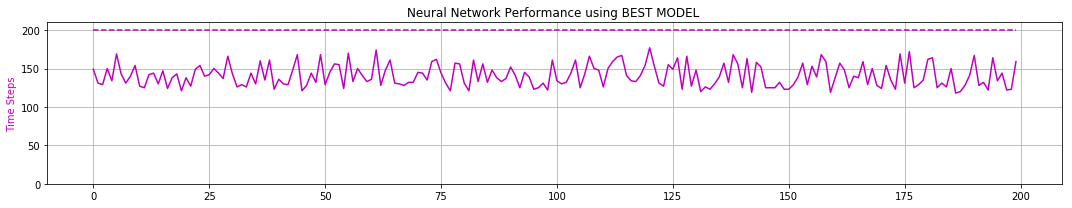

peak memory: 73798.72 MiB, increment: 65321.47 MiB
0 -max- [ 0.174  1.195  0.047  1.222  0.474]
0 -min- [-2.399 -2.923 -0.209 -1.799  0.425]

1 -max- [ 0.183  1.172  0.048  1.321  0.525]
1 -min- [-2.400 -2.768 -0.208 -1.770  0.477]

2 -max- [ 0.156  1.202  0.048  1.577  0.574]
2 -min- [-2.400 -2.767 -0.209 -1.765  0.525]

3 -max- [ 0.167  1.023  0.046  1.398  0.624]
3 -min- [-2.398 -2.745 -0.209 -1.470  0.575]

4 -max- [ 0.150  1.018  0.048  1.376  0.675]
4 -min- [-2.400 -2.789 -0.209 -1.464  0.625]

5 -max- [ 0.156  1.024  0.049  1.202  0.725]
5 -min- [-2.400 -2.623 -0.209 -1.659  0.675]

6 -max- [ 0.171  1.204  0.049  1.312  0.775]
6 -min- [-2.400 -2.613 -0.209 -1.668  0.725]

7 -max- [ 0.165  1.024  0.053  1.170  0.825]
7 -min- [-2.400 -2.587 -0.209 -1.477  0.776]

8 -max- [ 0.157  1.022  0.050  1.016  0.874]
8 -min- [-2.400 -2.600 -0.209 -1.463  0.825]

9 -max- [ 0.144  1.023  0.048  1.621  0.924]
9 -min- [-2.399 -2.584 -0.209 -1.638  0.875]

Quantization TIME:  0.58 minutes


ITER

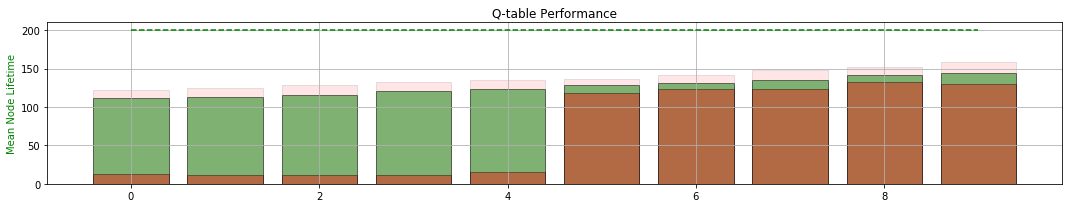

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 63.309	LOSS : 68.327	LOSS : 68.916	LOSS : 65.881	LOSS : 65.645	LOSS : 63.429	LOSS : 57.853	LOSS : 60.175	LOSS : 69.099	LOSS : 62.726	LOSS : 61.362	LOSS : 71.888	LOSS : 68.603	LOSS : 68.121	LOSS : 68.910	LOSS : 61.017	LOSS : 70.082	LOSS : 67.711	LOSS : 61.982	LOSS : 60.375	
Validating... MEAN TIME:  139.6
LOSS : 69.864	LOSS : 74.442	LOSS : 64.639	LOSS : 64.285	LOSS : 71.069	LOSS : 58.513	LOSS : 69.230	LOSS : 62.173	LOSS : 71.102	LOSS : 68.418	LOSS : 66.130	LOSS : 67.288	LOSS : 68.601	LOSS : 65.865	LOSS : 62.345	LOSS : 72.433	LOSS : 71.198	LOSS : 65.830	LOSS : 66.511	LOSS : 65.138	
Validating... MEAN TIME:  134.075
LOSS : 68.731	LOSS : 73.998	LOSS : 64.411	LOSS : 65.755	LOSS : 64.174	LOSS : 61.862	LOSS : 65.460	LOSS : 63.386	LOSS : 65.797	LOSS : 61.828	LOSS : 57.342	LOSS : 65.034	LOSS : 71.813	LOSS : 70.023	LOSS : 66.746	LOSS : 61.680	LOSS : 63.211	LOSS : 62.238	LOSS : 62.115	LOSS : 70.128	
Validati

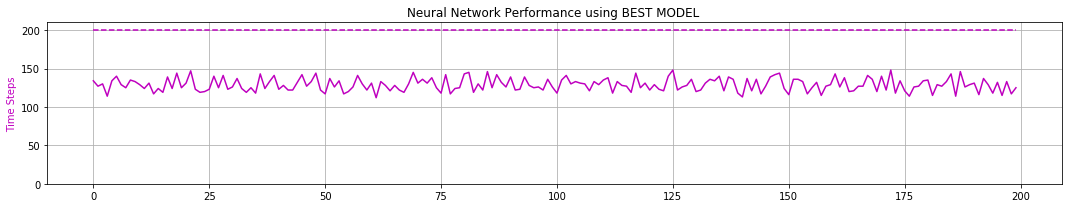

peak memory: 73817.87 MiB, increment: 65330.88 MiB
0 -max- [ 0.203  1.205  0.050  1.576  0.474]
0 -min- [-2.399 -2.981 -0.208 -1.753  0.425]

1 -max- [ 0.188  1.214  0.048  1.760  0.524]
1 -min- [-2.400 -2.957 -0.206 -1.809  0.476]

2 -max- [ 0.185  1.216  0.046  1.569  0.575]
2 -min- [-2.399 -2.920 -0.209 -1.833  0.525]

3 -max- [ 0.185  1.209  0.048  1.762  0.624]
3 -min- [-2.400 -2.815 -0.207 -1.754  0.575]

4 -max- [ 0.176  1.182  0.049  1.553  0.675]
4 -min- [-2.399 -2.956 -0.209 -1.747  0.625]

5 -max- [ 0.174  1.214  0.070  1.802  0.725]
5 -min- [-2.400 -2.799 -0.208 -1.873  0.675]

6 -max- [ 0.190  1.217  0.049  1.727  0.775]
6 -min- [-2.399 -2.951 -0.206 -1.740  0.725]

7 -max- [ 0.180  1.215  0.052  1.721  0.825]
7 -min- [-2.399 -2.805 -0.209 -1.752  0.775]

8 -max- [ 0.197  1.214  0.056  1.771  0.875]
8 -min- [-2.399 -2.765 -0.208 -1.683  0.828]

9 -max- [ 0.186  1.171  0.048  1.625  0.924]
9 -min- [-2.399 -2.768 -0.208 -1.686  0.875]

Quantization TIME:  0.59 minutes


ITER

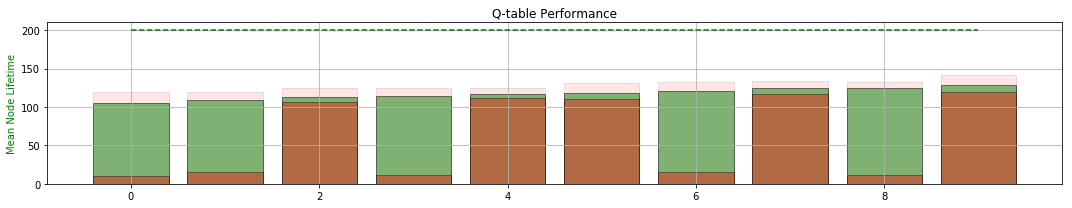

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.820	LOSS : 64.693	LOSS : 61.645	LOSS : 71.008	LOSS : 69.703	LOSS : 71.673	LOSS : 69.280	LOSS : 70.804	LOSS : 75.530	LOSS : 68.023	LOSS : 69.381	LOSS : 59.799	LOSS : 71.739	LOSS : 60.495	LOSS : 71.326	LOSS : 74.215	LOSS : 63.822	LOSS : 66.161	LOSS : 67.481	LOSS : 66.024	
Validating... MEAN TIME:  112.405
LOSS : 66.288	LOSS : 61.352	LOSS : 67.152	LOSS : 63.512	LOSS : 60.561	LOSS : 63.390	LOSS : 65.536	LOSS : 65.814	LOSS : 74.211	LOSS : 58.953	LOSS : 59.740	LOSS : 71.937	LOSS : 65.915	LOSS : 67.964	LOSS : 60.297	LOSS : 64.312	LOSS : 61.586	LOSS : 65.113	LOSS : 61.463	LOSS : 67.814	
Validating... MEAN TIME:  115.8
LOSS : 65.480	LOSS : 68.808	LOSS : 66.785	LOSS : 65.056	LOSS : 65.260	LOSS : 62.699	LOSS : 70.566	LOSS : 71.361	LOSS : 61.140	LOSS : 63.415	LOSS : 66.256	LOSS : 64.237	LOSS : 66.384	LOSS : 64.121	LOSS : 65.487	LOSS : 57.852	LOSS : 61.398	LOSS : 75.391	LOSS : 63.589	LOSS : 64.277	
Validati

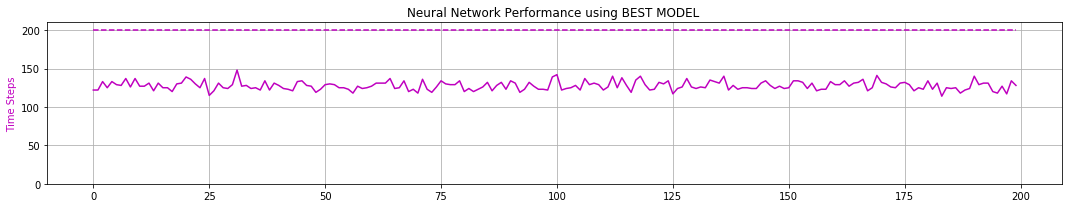

peak memory: 74075.39 MiB, increment: 65558.40 MiB
0 -max- [ 0.214  1.202  0.048  1.329  0.475]
0 -min- [-2.399 -3.165 -0.209 -1.843  0.425]

1 -max- [ 0.185  1.216  0.046  1.348  0.525]
1 -min- [-2.400 -3.188 -0.206 -1.770  0.476]

2 -max- [ 0.185  1.210  0.048  1.403  0.575]
2 -min- [-2.399 -3.121 -0.199 -1.765  0.525]

3 -max- [ 0.182  1.215  0.049  1.180  0.624]
3 -min- [-2.399 -2.993 -0.205 -1.774  0.575]

4 -max- [ 0.187  1.214  0.049  1.386  0.675]
4 -min- [-2.400 -3.195 -0.196 -1.752  0.625]

5 -max- [ 0.190  1.200  0.049  1.322  0.724]
5 -min- [-2.400 -2.933 -0.184 -1.740  0.677]

6 -max- [ 0.157  1.215  0.050  1.290  0.775]
6 -min- [-2.399 -3.181 -0.203 -1.679  0.725]

7 -max- [ 0.197  1.214  0.048  1.217  0.825]
7 -min- [-2.399 -2.900 -0.190 -1.676  0.775]

8 -max- [ 0.203  1.370  0.048  1.256  0.874]
8 -min- [-2.400 -2.809 -0.208 -2.031  0.825]

9 -max- [ 0.171  1.215  0.051  1.332  0.924]
9 -min- [-2.399 -2.971 -0.206 -1.680  0.875]

Quantization TIME:  0.59 minutes


ITER

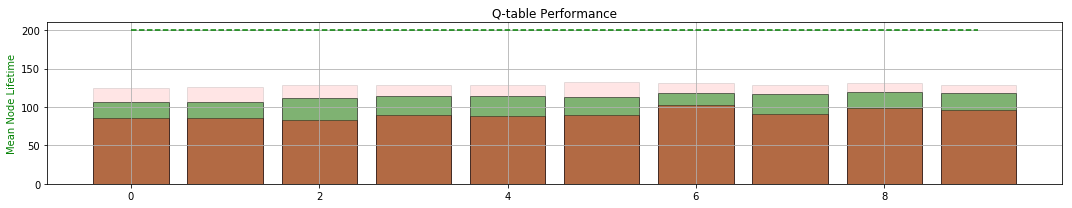

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 74.177	LOSS : 69.031	LOSS : 69.308	LOSS : 75.159	LOSS : 69.706	LOSS : 66.430	LOSS : 68.855	LOSS : 68.212	LOSS : 72.622	LOSS : 69.912	LOSS : 70.550	LOSS : 64.063	LOSS : 67.091	LOSS : 71.117	LOSS : 68.576	LOSS : 71.108	LOSS : 70.857	LOSS : 62.837	LOSS : 61.452	LOSS : 69.257	
Validating... MEAN TIME:  112.695
LOSS : 69.961	LOSS : 73.792	LOSS : 68.643	LOSS : 69.579	LOSS : 70.749	LOSS : 65.703	LOSS : 67.171	LOSS : 67.251	LOSS : 70.099	LOSS : 72.437	LOSS : 61.214	LOSS : 66.085	LOSS : 70.756	LOSS : 66.102	LOSS : 62.053	LOSS : 68.465	LOSS : 65.501	LOSS : 71.911	LOSS : 69.513	LOSS : 73.969	
Validating... MEAN TIME:  118.815
LOSS : 66.896	LOSS : 65.611	LOSS : 75.327	LOSS : 67.162	LOSS : 61.786	LOSS : 68.984	LOSS : 71.588	LOSS : 67.114	LOSS : 80.187	LOSS : 52.690	LOSS : 65.080	LOSS : 62.340	LOSS : 66.131	LOSS : 61.605	LOSS : 60.858	LOSS : 55.374	LOSS : 65.110	LOSS : 73.733	LOSS : 68.150	LOSS : 63.399	
Valida

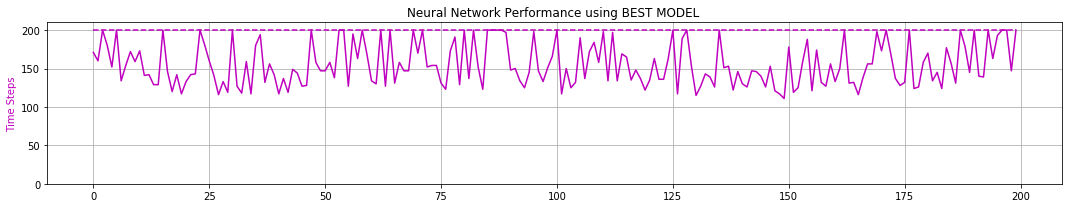

peak memory: 74137.43 MiB, increment: 65621.31 MiB
0 -max- [ 0.143  0.991  0.046  1.264  0.474]
0 -min- [-2.399 -3.548 -0.209 -1.364  0.425]

1 -max- [ 0.140  0.823  0.048  1.099  0.524]
1 -min- [-2.399 -3.311 -0.209 -1.169  0.477]

2 -max- [ 0.142  0.829  0.049  1.104  0.575]
2 -min- [-2.399 -3.323 -0.209 -1.183  0.526]

3 -max- [ 0.141  0.992  0.056  1.099  0.624]
3 -min- [-2.398 -3.304 -0.209 -1.394  0.575]

4 -max- [ 0.152  1.021  0.049  1.101  0.674]
4 -min- [-2.400 -3.356 -0.209 -1.424  0.625]

5 -max- [ 0.148  0.940  0.050  1.249  0.725]
5 -min- [-2.399 -3.466 -0.209 -1.369  0.676]

6 -max- [ 0.154  0.828  0.048  1.004  0.774]
6 -min- [-2.400 -3.348 -0.207 -1.179  0.725]

7 -max- [ 0.124  0.995  0.048  1.157  0.824]
7 -min- [-2.399 -3.344 -0.209 -1.548  0.775]

8 -max- [ 0.149  0.930  0.051  1.226  0.875]
8 -min- [-2.400 -3.486 -0.207 -1.351  0.825]

9 -max- [ 0.123  0.823  0.049  1.548  0.925]
9 -min- [-2.399 -3.708 -0.203 -1.167  0.875]

Quantization TIME:  0.58 minutes


ITER

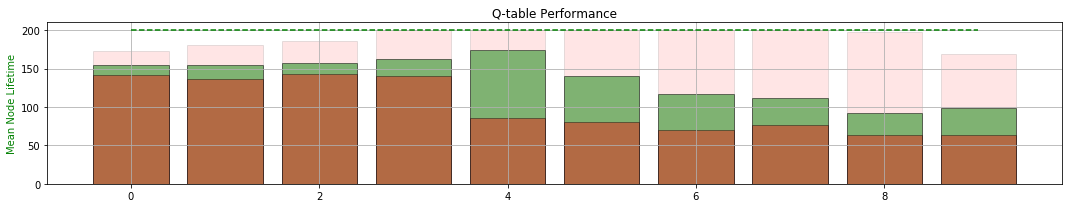

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.049	LOSS : 98.192	LOSS : 76.285	LOSS : 81.374	LOSS : 70.849	LOSS : 73.376	LOSS : 72.822	LOSS : 65.003	LOSS : 65.706	LOSS : 82.128	LOSS : 61.189	LOSS : 69.138	LOSS : 83.609	LOSS : 84.013	LOSS : 79.359	LOSS : 82.463	LOSS : 72.067	LOSS : 68.095	LOSS : 76.941	LOSS : 77.707	
Validating... MEAN TIME:  19.19
LOSS : 71.523	LOSS : 72.930	LOSS : 68.528	LOSS : 70.551	LOSS : 77.500	LOSS : 72.152	LOSS : 61.758	LOSS : 71.913	LOSS : 75.151	LOSS : 70.415	LOSS : 65.502	LOSS : 69.977	LOSS : 80.196	LOSS : 69.154	LOSS : 68.678	LOSS : 64.959	LOSS : 71.121	LOSS : 70.212	LOSS : 72.245	LOSS : 67.698	
Validating... MEAN TIME:  98.425
LOSS : 70.055	LOSS : 67.539	LOSS : 70.259	LOSS : 76.430	LOSS : 71.862	LOSS : 66.523	LOSS : 78.890	LOSS : 74.040	LOSS : 80.142	LOSS : 68.655	LOSS : 64.034	LOSS : 67.492	LOSS : 80.228	LOSS : 75.172	LOSS : 82.854	LOSS : 73.120	LOSS : 71.509	LOSS : 71.494	LOSS : 71.654	LOSS : 72.986	
Validatin

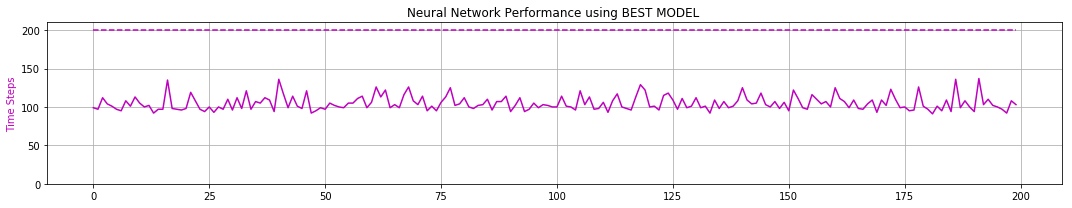

peak memory: 73996.16 MiB, increment: 65478.86 MiB
0 -max- [ 2.399  1.824  0.119  1.116  0.471]
0 -min- [-0.131 -0.762 -0.050 -0.863  0.425]

1 -max- [ 2.400  1.877  0.119  0.976  0.525]
1 -min- [-0.114 -0.632 -0.048 -0.791  0.475]

2 -max- [ 2.400  1.865  0.145  1.137  0.574]
2 -min- [-0.127 -0.819 -0.048 -0.737  0.525]

3 -max- [ 2.400  1.879  0.116  0.914  0.625]
3 -min- [-0.143 -0.631 -0.047 -0.769  0.575]

4 -max- [ 2.400  2.045  0.151  1.132  0.674]
4 -min- [-0.822 -1.319 -0.209 -0.855  0.626]

5 -max- [ 2.400  1.970  0.112  1.105  0.725]
5 -min- [-2.354 -2.927 -0.209 -1.226  0.676]

6 -max- [ 2.397  1.870  0.121  1.186  0.775]
6 -min- [-2.380 -3.495 -0.209 -1.361  0.725]

7 -max- [ 2.398  1.891  0.107  0.919  0.824]
7 -min- [-2.382 -3.281 -0.209 -1.303  0.776]

8 -max- [ 2.399  1.877  0.100  1.199  0.875]
8 -min- [-2.397 -3.543 -0.209 -1.389  0.825]

9 -max- [ 2.372  1.840  0.115  1.251  0.925]
9 -min- [-2.393 -3.524 -0.209 -1.388  0.875]

Quantization TIME:  0.58 minutes


ITER

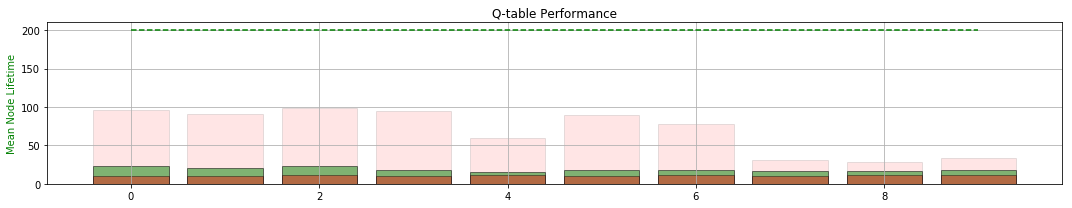

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 102.790	LOSS : 111.947	LOSS : 108.458	LOSS : 103.448	LOSS : 93.611	LOSS : 107.534	LOSS : 107.215	LOSS : 98.105	LOSS : 104.343	LOSS : 92.369	LOSS : 105.516	LOSS : 102.637	LOSS : 111.115	LOSS : 103.339	LOSS : 99.797	LOSS : 101.998	LOSS : 106.924	LOSS : 109.287	LOSS : 106.600	LOSS : 112.333	
Validating... MEAN TIME:  130.73
LOSS : 103.372	LOSS : 106.571	LOSS : 105.739	LOSS : 109.086	LOSS : 91.688	LOSS : 109.567	LOSS : 103.333	LOSS : 103.185	LOSS : 102.471	LOSS : 93.860	LOSS : 114.942	LOSS : 98.916	LOSS : 101.771	LOSS : 111.443	LOSS : 97.017	LOSS : 98.214	LOSS : 99.298	LOSS : 105.228	LOSS : 102.748	LOSS : 114.192	
Validating... MEAN TIME:  174.575
LOSS : 118.024	LOSS : 102.984	LOSS : 107.012	LOSS : 93.621	LOSS : 109.921	LOSS : 106.653	LOSS : 104.326	LOSS : 93.066	LOSS : 106.012	LOSS : 97.658	LOSS : 92.345	LOSS : 98.558	LOSS : 99.782	LOSS : 101.048	LOSS : 99.142	LOSS : 100.441	LOSS : 100.449	LOSS : 96.

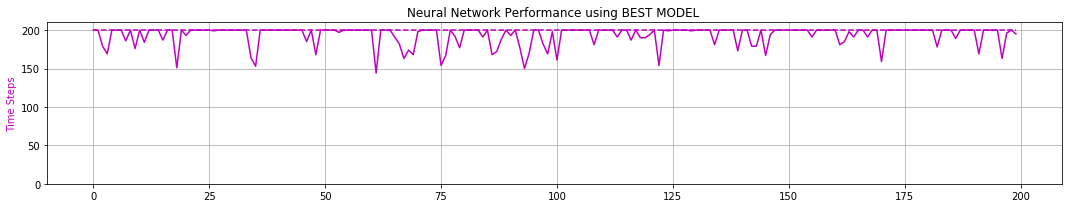

peak memory: 73854.07 MiB, increment: 65337.90 MiB
0 -max- [ 0.211  1.158  0.049  1.124  0.475]
0 -min- [-2.397 -3.660 -0.209 -1.653  0.425]

1 -max- [ 0.204  1.028  0.049  1.184  0.525]
1 -min- [-2.390 -3.719 -0.209 -1.608  0.475]

2 -max- [ 0.228  0.983  0.049  0.905  0.575]
2 -min- [-2.399 -3.542 -0.209 -1.638  0.525]

3 -max- [ 0.226  1.026  0.050  0.942  0.625]
3 -min- [-2.349 -3.494 -0.209 -1.592  0.576]

4 -max- [ 0.238  1.028  0.048  0.652  0.674]
4 -min- [-0.774 -1.869 -0.209 -1.609  0.628]

5 -max- [ 0.201  1.003  0.048  0.854  0.725]
5 -min- [-2.380 -3.333 -0.209 -1.611  0.675]

6 -max- [ 0.226  1.025  0.051  0.610  0.774]
6 -min- [-1.602 -2.586 -0.209 -1.666  0.725]

7 -max- [ 0.204  0.838  0.049  0.322  0.824]
7 -min- [-0.049 -0.231 -0.209 -1.461  0.775]

8 -max- [ 0.212  0.999  0.050  0.049  0.875]
8 -min- [-0.047 -0.174 -0.209 -1.739  0.825]

9 -max- [ 0.227  1.031  0.050  0.357  0.925]
9 -min- [-0.050 -0.545 -0.209 -1.674  0.875]

Quantization TIME:  0.58 minutes


ITER

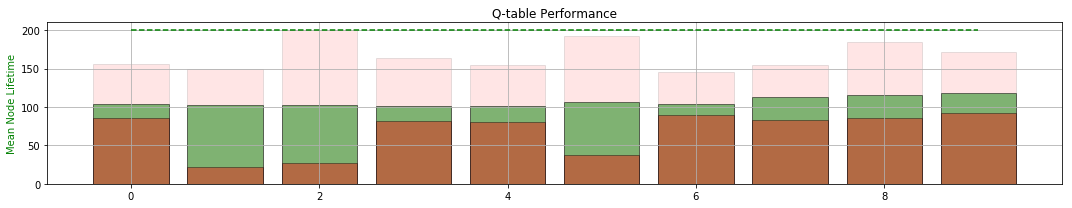

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 103.058	LOSS : 108.287	LOSS : 103.217	LOSS : 109.288	LOSS : 106.379	LOSS : 96.445	LOSS : 101.576	LOSS : 104.976	LOSS : 112.908	LOSS : 98.907	LOSS : 98.045	LOSS : 92.171	LOSS : 105.237	LOSS : 95.329	LOSS : 109.792	LOSS : 97.330	LOSS : 101.820	LOSS : 105.298	LOSS : 99.178	LOSS : 115.766	
Validating... MEAN TIME:  96.95
LOSS : 103.334	LOSS : 105.956	LOSS : 103.887	LOSS : 104.776	LOSS : 104.150	LOSS : 106.747	LOSS : 101.253	LOSS : 114.811	LOSS : 102.429	LOSS : 99.221	LOSS : 101.493	LOSS : 111.947	LOSS : 114.815	LOSS : 109.173	LOSS : 99.431	LOSS : 90.096	LOSS : 107.309	LOSS : 103.249	LOSS : 108.621	LOSS : 113.462	
Validating... MEAN TIME:  129.32
LOSS : 100.784	LOSS : 105.046	LOSS : 119.885	LOSS : 95.266	LOSS : 106.877	LOSS : 101.401	LOSS : 100.490	LOSS : 100.724	LOSS : 104.811	LOSS : 108.223	LOSS : 102.083	LOSS : 95.863	LOSS : 114.750	LOSS : 112.042	LOSS : 111.990	LOSS : 106.514	LOSS : 102.556	LOSS : 

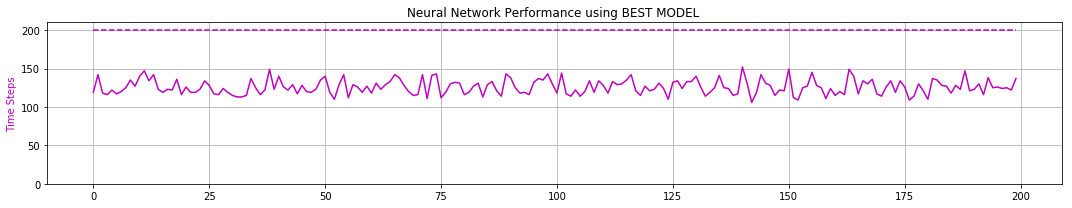

peak memory: 73897.04 MiB, increment: 65379.69 MiB
0 -max- [ 0.158  0.595  0.049  1.177  0.474]
0 -min- [-2.398 -3.553 -0.209 -1.095  0.425]

1 -max- [ 0.204  0.612  0.051  0.918  0.525]
1 -min- [-2.400 -3.173 -0.209 -1.084  0.475]

2 -max- [ 0.157  0.638  0.050  0.965  0.575]
2 -min- [-2.400 -3.291 -0.209 -1.111  0.525]

3 -max- [ 0.207  0.628  0.048  1.154  0.624]
3 -min- [-2.391 -3.494 -0.209 -1.091  0.576]

4 -max- [ 0.147  0.761  0.048  1.203  0.674]
4 -min- [-2.392 -3.467 -0.209 -1.344  0.628]

5 -max- [ 0.199  0.636  0.051  1.212  0.725]
5 -min- [-2.397 -3.484 -0.209 -1.099  0.676]

6 -max- [ 0.136  0.611  0.049  0.984  0.775]
6 -min- [-2.386 -3.312 -0.209 -1.105  0.725]

7 -max- [ 0.140  0.620  0.051  1.106  0.825]
7 -min- [-2.399 -3.310 -0.209 -1.070  0.776]

8 -max- [ 0.180  0.614  0.051  1.158  0.875]
8 -min- [-2.396 -3.301 -0.209 -1.115  0.825]

9 -max- [ 0.139  0.630  0.049  1.190  0.925]
9 -min- [-2.395 -3.362 -0.209 -1.072  0.875]

Quantization TIME:  0.59 minutes


ITER

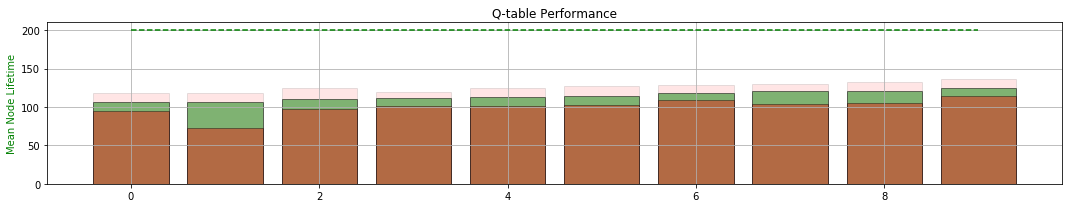

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 132.040	LOSS : 117.818	LOSS : 123.149	LOSS : 87.458	LOSS : 95.335	LOSS : 95.530	LOSS : 94.886	LOSS : 90.550	LOSS : 109.161	LOSS : 114.328	LOSS : 100.234	LOSS : 80.192	LOSS : 97.327	LOSS : 83.250	LOSS : 87.401	LOSS : 92.580	LOSS : 90.168	LOSS : 82.802	LOSS : 82.514	LOSS : 92.011	
Validating... MEAN TIME:  122.26
LOSS : 98.834	LOSS : 89.491	LOSS : 91.932	LOSS : 87.591	LOSS : 83.915	LOSS : 90.516	LOSS : 81.113	LOSS : 96.949	LOSS : 94.309	LOSS : 77.236	LOSS : 84.044	LOSS : 89.480	LOSS : 92.978	LOSS : 77.423	LOSS : 81.353	LOSS : 94.956	LOSS : 76.340	LOSS : 75.130	LOSS : 93.633	LOSS : 80.026	
Validating... MEAN TIME:  199.705
LOSS : 93.079	LOSS : 76.065	LOSS : 84.561	LOSS : 88.073	LOSS : 75.691	LOSS : 87.074	LOSS : 97.945	LOSS : 80.884	LOSS : 89.687	LOSS : 87.374	LOSS : 72.791	LOSS : 78.853	LOSS : 76.854	LOSS : 77.653	LOSS : 78.323	LOSS : 79.022	LOSS : 92.374	LOSS : 87.102	LOSS : 97.209	LOSS : 77.431	
V

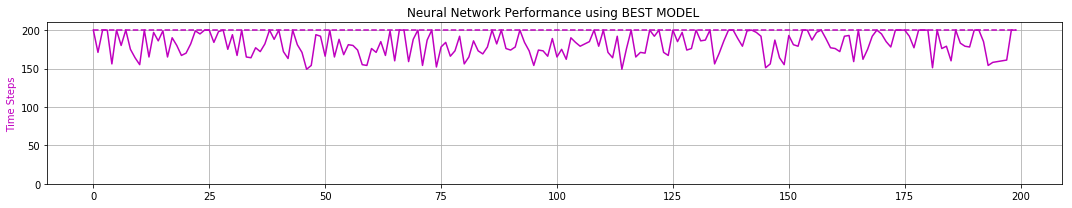

peak memory: 73556.45 MiB, increment: 65023.11 MiB
0 -max- [ 0.167  1.003  0.053  1.306  0.475]
0 -min- [-2.399 -3.663 -0.209 -1.375  0.426]

1 -max- [ 0.150  0.939  0.050  1.304  0.525]
1 -min- [-2.400 -3.543 -0.209 -1.387  0.478]

2 -max- [ 0.160  0.829  0.048  1.310  0.574]
2 -min- [-2.400 -3.560 -0.209 -1.289  0.525]

3 -max- [ 0.132  0.976  0.048  1.314  0.625]
3 -min- [-2.400 -3.526 -0.209 -1.525  0.575]

4 -max- [ 0.157  0.972  0.051  1.311  0.675]
4 -min- [-2.398 -3.528 -0.209 -1.408  0.626]

5 -max- [ 0.129  0.823  0.049  1.293  0.725]
5 -min- [-2.399 -3.472 -0.209 -1.592  0.675]

6 -max- [ 0.130  0.823  0.050  1.306  0.775]
6 -min- [-2.400 -3.367 -0.209 -1.338  0.726]

7 -max- [ 0.146  0.821  0.050  1.277  0.824]
7 -min- [-2.400 -3.365 -0.209 -1.381  0.775]

8 -max- [ 0.125  0.807  0.049  1.279  0.875]
8 -min- [-2.400 -3.352 -0.209 -1.520  0.826]

9 -max- [ 0.114  0.824  0.050  1.232  0.925]
9 -min- [-2.400 -3.192 -0.209 -1.270  0.876]

Quantization TIME:  0.59 minutes


ITER

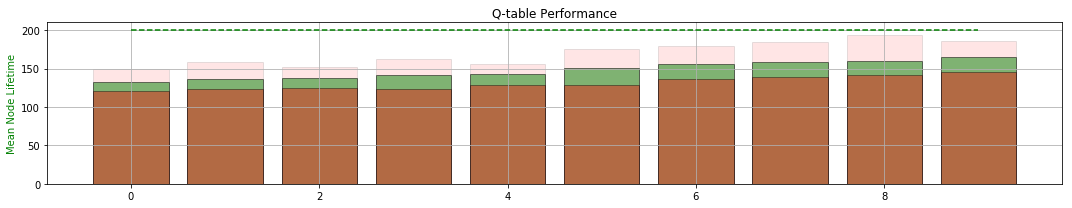

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 80.725	LOSS : 84.798	LOSS : 88.681	LOSS : 81.397	LOSS : 74.658	LOSS : 68.030	LOSS : 76.387	LOSS : 75.019	LOSS : 76.087	LOSS : 70.638	LOSS : 63.018	LOSS : 66.569	LOSS : 57.563	LOSS : 52.116	LOSS : 67.631	LOSS : 72.091	LOSS : 70.209	LOSS : 61.673	LOSS : 63.302	LOSS : 72.376	
Validating... MEAN TIME:  131.47
LOSS : 69.344	LOSS : 64.611	LOSS : 53.253	LOSS : 53.117	LOSS : 59.036	LOSS : 58.295	LOSS : 59.682	LOSS : 72.885	LOSS : 68.821	LOSS : 63.007	LOSS : 64.764	LOSS : 61.889	LOSS : 64.686	LOSS : 72.870	LOSS : 66.525	LOSS : 67.981	LOSS : 55.504	LOSS : 63.739	LOSS : 69.458	LOSS : 69.960	
Validating... MEAN TIME:  108.165
LOSS : 74.409	LOSS : 62.272	LOSS : 59.639	LOSS : 66.676	LOSS : 59.475	LOSS : 58.620	LOSS : 64.641	LOSS : 59.333	LOSS : 65.286	LOSS : 65.566	LOSS : 57.074	LOSS : 66.639	LOSS : 69.049	LOSS : 63.666	LOSS : 71.093	LOSS : 68.651	LOSS : 59.168	LOSS : 69.345	LOSS : 71.172	LOSS : 75.655	
Validat

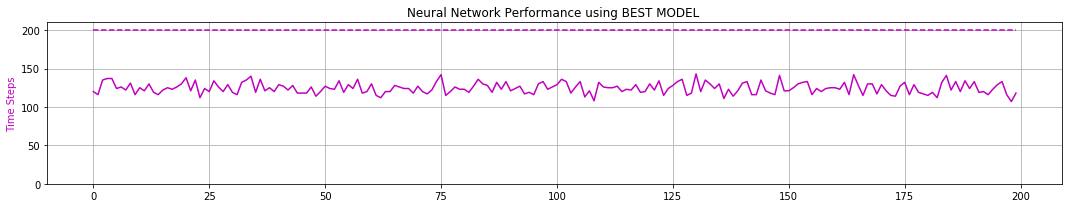

peak memory: 73600.20 MiB, increment: 65065.46 MiB
0 -max- [ 0.136  0.632  0.050  0.722  0.475]
0 -min- [-2.171 -2.224 -0.209 -1.075  0.425]

1 -max- [ 0.151  0.634  0.048  0.577  0.525]
1 -min- [-2.206 -2.318 -0.209 -1.112  0.475]

2 -max- [ 0.111  0.633  0.048  0.685  0.575]
2 -min- [-2.245 -2.233 -0.209 -1.140  0.527]

3 -max- [ 0.141  0.631  0.051  0.708  0.624]
3 -min- [-2.295 -2.232 -0.209 -1.380  0.576]

4 -max- [ 0.112  0.760  0.049  0.888  0.674]
4 -min- [-2.262 -2.235 -0.209 -1.324  0.625]

5 -max- [ 0.120  0.945  0.050  0.743  0.724]
5 -min- [-2.335 -2.395 -0.209 -1.424  0.675]

6 -max- [ 0.128  0.622  0.050  0.701  0.775]
6 -min- [-2.296 -2.216 -0.209 -1.372  0.725]

7 -max- [ 0.118  0.616  0.049  0.750  0.825]
7 -min- [-2.395 -2.378 -0.209 -1.279  0.777]

8 -max- [ 0.106  0.824  0.050  0.759  0.874]
8 -min- [-2.399 -2.377 -0.209 -1.332  0.825]

9 -max- [ 0.111  0.630  0.050  0.689  0.923]
9 -min- [-2.397 -2.231 -0.209 -1.370  0.877]

Quantization TIME:  0.58 minutes


ITER

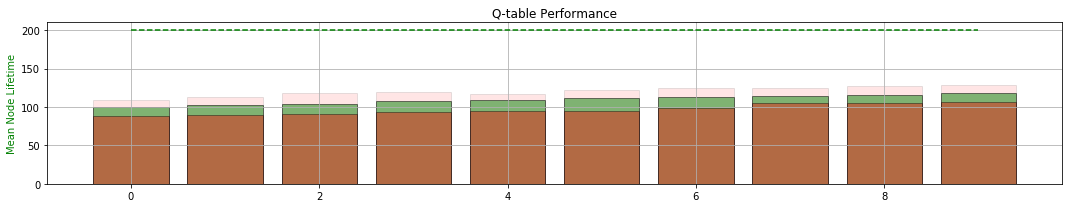

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.370	LOSS : 87.970	LOSS : 80.752	LOSS : 86.993	LOSS : 79.918	LOSS : 87.331	LOSS : 85.570	LOSS : 96.443	LOSS : 80.010	LOSS : 91.992	LOSS : 101.941	LOSS : 100.062	LOSS : 90.981	LOSS : 98.436	LOSS : 100.405	LOSS : 100.857	LOSS : 96.456	LOSS : 86.196	LOSS : 98.825	LOSS : 99.551	
Validating... MEAN TIME:  133.63
LOSS : 118.279	LOSS : 118.946	LOSS : 123.971	LOSS : 107.367	LOSS : 113.673	LOSS : 135.573	LOSS : 108.280	LOSS : 128.323	LOSS : 113.969	LOSS : 106.356	LOSS : 107.651	LOSS : 103.888	LOSS : 112.677	LOSS : 100.968	LOSS : 95.725	LOSS : 101.704	LOSS : 86.838	LOSS : 84.989	LOSS : 79.976	LOSS : 68.913	
Validating... MEAN TIME:  129.41
LOSS : 77.491	LOSS : 68.701	LOSS : 79.098	LOSS : 76.087	LOSS : 77.443	LOSS : 76.936	LOSS : 77.485	LOSS : 65.970	LOSS : 70.879	LOSS : 72.094	LOSS : 76.759	LOSS : 72.603	LOSS : 74.720	LOSS : 64.570	LOSS : 72.244	LOSS : 68.990	LOSS : 77.257	LOSS : 75.525	LOSS : 71.125	LOSS

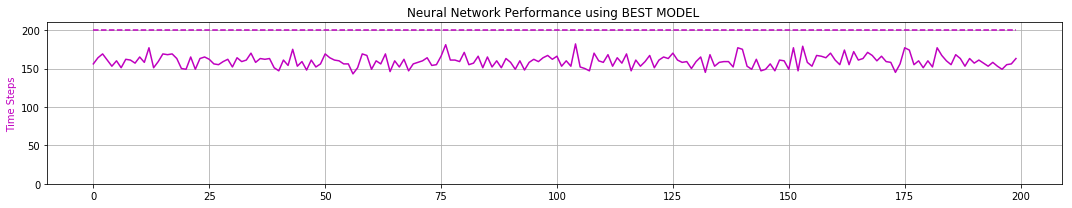

peak memory: 74061.88 MiB, increment: 65528.25 MiB
0 -max- [ 0.166  0.978  0.048  0.629  0.475]
0 -min- [-2.392 -2.970 -0.209 -1.421  0.426]

1 -max- [ 0.138  0.781  0.048  0.626  0.523]
1 -min- [-2.399 -3.089 -0.209 -1.097  0.475]

2 -max- [ 0.163  0.825  0.051  0.621  0.575]
2 -min- [-2.393 -3.060 -0.209 -1.157  0.525]

3 -max- [ 0.132  0.825  0.049  0.632  0.624]
3 -min- [-2.395 -3.115 -0.209 -1.190  0.575]

4 -max- [ 0.139  0.630  0.050  0.623  0.674]
4 -min- [-2.397 -2.961 -0.209 -0.918  0.625]

5 -max- [ 0.160  0.795  0.050  0.684  0.725]
5 -min- [-2.400 -2.941 -0.209 -1.131  0.675]

6 -max- [ 0.133  0.634  0.049  0.636  0.775]
6 -min- [-2.399 -2.923 -0.209 -0.983  0.726]

7 -max- [ 0.130  0.783  0.050  0.735  0.825]
7 -min- [-2.396 -2.964 -0.209 -1.100  0.775]

8 -max- [ 0.137  0.632  0.055  0.619  0.874]
8 -min- [-2.400 -2.941 -0.209 -0.921  0.825]

9 -max- [ 0.132  0.631  0.050  0.628  0.925]
9 -min- [-2.400 -2.872 -0.209 -0.911  0.875]

Quantization TIME:  0.59 minutes


ITER

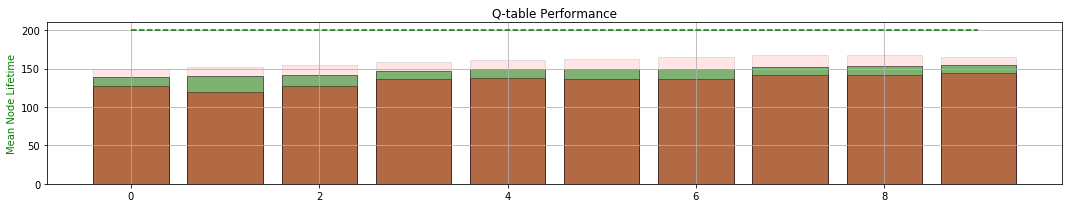

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 81.422	LOSS : 83.537	LOSS : 95.293	LOSS : 103.480	LOSS : 103.451	LOSS : 99.138	LOSS : 117.817	LOSS : 88.832	LOSS : 107.522	LOSS : 96.867	LOSS : 97.775	LOSS : 99.540	LOSS : 87.341	LOSS : 89.559	LOSS : 110.092	LOSS : 95.061	LOSS : 93.777	LOSS : 98.626	LOSS : 86.952	LOSS : 101.486	
Validating... MEAN TIME:  108.395
LOSS : 104.860	LOSS : 95.406	LOSS : 104.240	LOSS : 107.722	LOSS : 105.374	LOSS : 112.423	LOSS : 118.115	LOSS : 114.853	LOSS : 105.721	LOSS : 105.781	LOSS : 123.025	LOSS : 90.416	LOSS : 107.266	LOSS : 109.307	LOSS : 106.306	LOSS : 111.994	LOSS : 111.866	LOSS : 110.977	LOSS : 118.213	LOSS : 114.913	
Validating... MEAN TIME:  78.43
LOSS : 119.228	LOSS : 121.708	LOSS : 118.384	LOSS : 107.627	LOSS : 111.437	LOSS : 130.149	LOSS : 105.773	LOSS : 134.693	LOSS : 137.405	LOSS : 109.337	LOSS : 107.169	LOSS : 145.840	LOSS : 107.628	LOSS : 107.201	LOSS : 107.501	LOSS : 110.100	LOSS : 120.692	LOSS : 103

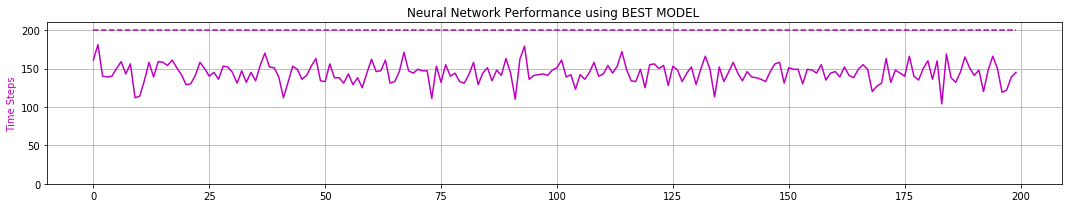

peak memory: 73948.55 MiB, increment: 65413.73 MiB
0 -max- [ 0.144  0.950  0.048  1.188  0.475]
0 -min- [-2.400 -2.738 -0.209 -1.380  0.426]

1 -max- [ 0.157  1.155  0.051  1.169  0.525]
1 -min- [-2.399 -2.719 -0.209 -1.709  0.476]

2 -max- [ 0.134  0.967  0.049  0.916  0.575]
2 -min- [-2.400 -2.609 -0.209 -1.433  0.525]

3 -max- [ 0.120  0.950  0.050  0.851  0.625]
3 -min- [-2.399 -2.801 -0.209 -1.363  0.576]

4 -max- [ 0.155  1.012  0.050  0.937  0.675]
4 -min- [-2.399 -2.591 -0.209 -1.457  0.626]

5 -max- [ 0.121  0.829  0.049  0.749  0.725]
5 -min- [-2.400 -2.604 -0.207 -1.184  0.676]

6 -max- [ 0.122  1.019  0.050  0.908  0.775]
6 -min- [-2.398 -2.423 -0.209 -1.455  0.725]

7 -max- [ 0.121  0.827  0.050  0.716  0.824]
7 -min- [-2.400 -2.387 -0.209 -1.187  0.775]

8 -max- [ 0.129  0.826  0.050  0.865  0.875]
8 -min- [-2.400 -2.409 -0.206 -1.187  0.826]

9 -max- [ 0.119  0.827  0.048  0.843  0.924]
9 -min- [-2.400 -2.360 -0.209 -1.187  0.875]

Quantization TIME:  0.58 minutes


ITER

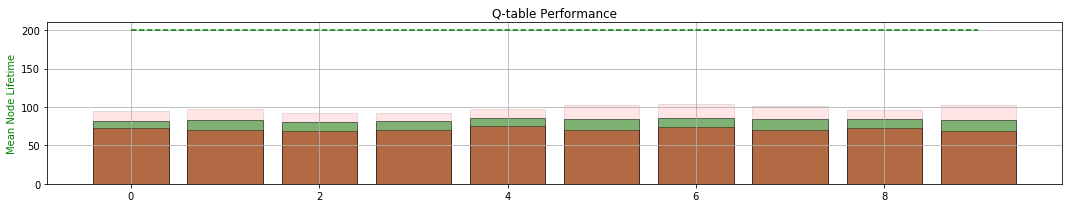

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 115.241	LOSS : 117.869	LOSS : 100.277	LOSS : 95.793	LOSS : 103.248	LOSS : 110.228	LOSS : 100.941	LOSS : 86.949	LOSS : 104.869	LOSS : 115.796	LOSS : 111.519	LOSS : 82.833	LOSS : 109.573	LOSS : 100.497	LOSS : 99.060	LOSS : 86.062	LOSS : 90.850	LOSS : 104.049	LOSS : 96.493	LOSS : 97.421	
Validating... MEAN TIME:  116.785
LOSS : 106.303	LOSS : 110.748	LOSS : 103.840	LOSS : 99.330	LOSS : 102.766	LOSS : 87.092	LOSS : 107.446	LOSS : 119.351	LOSS : 88.563	LOSS : 102.875	LOSS : 97.235	LOSS : 103.963	LOSS : 104.158	LOSS : 89.750	LOSS : 100.243	LOSS : 102.067	LOSS : 96.865	LOSS : 87.201	LOSS : 94.293	LOSS : 102.143	
Validating... MEAN TIME:  150.82
LOSS : 98.624	LOSS : 102.419	LOSS : 103.729	LOSS : 99.803	LOSS : 100.595	LOSS : 112.949	LOSS : 101.406	LOSS : 102.535	LOSS : 98.580	LOSS : 95.894	LOSS : 104.901	LOSS : 105.861	LOSS : 100.670	LOSS : 96.674	LOSS : 98.985	LOSS : 101.606	LOSS : 110.244	LOSS : 99.475	L

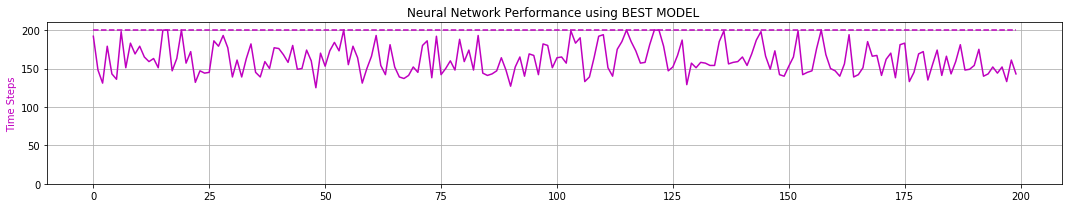

peak memory: 74123.89 MiB, increment: 65588.02 MiB
0 -max- [ 0.163  0.735  0.051  0.586  0.474]
0 -min- [-1.014 -1.777 -0.209 -1.064  0.425]

1 -max- [ 0.156  0.634  0.049  0.655  0.525]
1 -min- [-0.974 -1.688 -0.209 -0.882  0.475]

2 -max- [ 0.145  0.820  0.050  0.676  0.575]
2 -min- [-0.945 -1.685 -0.209 -1.126  0.526]

3 -max- [ 0.160  0.622  0.050  0.652  0.625]
3 -min- [-0.956 -1.779 -0.209 -0.887  0.575]

4 -max- [ 0.137  0.628  0.049  0.693  0.675]
4 -min- [-0.979 -1.686 -0.209 -0.885  0.625]

5 -max- [ 0.131  0.630  0.050  0.645  0.724]
5 -min- [-0.972 -1.689 -0.209 -0.877  0.676]

6 -max- [ 0.136  0.600  0.055  0.647  0.775]
6 -min- [-1.017 -1.878 -0.209 -0.896  0.726]

7 -max- [ 0.132  0.575  0.050  0.649  0.825]
7 -min- [-0.949 -1.685 -0.209 -0.881  0.776]

8 -max- [ 0.149  0.562  0.048  0.818  0.874]
8 -min- [-0.982 -1.643 -0.209 -0.859  0.826]

9 -max- [ 0.154  0.633  0.050  0.603  0.923]
9 -min- [-1.004 -1.791 -0.209 -0.981  0.875]

Quantization TIME:  0.59 minutes


ITER

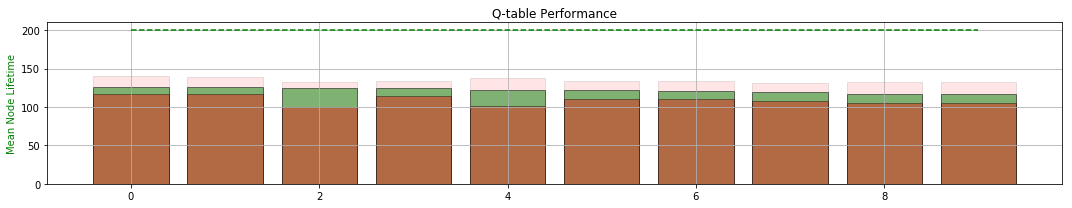

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.958	LOSS : 107.015	LOSS : 119.383	LOSS : 90.041	LOSS : 106.288	LOSS : 109.109	LOSS : 77.802	LOSS : 98.568	LOSS : 104.931	LOSS : 96.029	LOSS : 93.182	LOSS : 83.448	LOSS : 90.381	LOSS : 85.528	LOSS : 105.805	LOSS : 87.063	LOSS : 80.402	LOSS : 71.089	LOSS : 101.911	LOSS : 77.626	
Validating... MEAN TIME:  90.515
LOSS : 93.367	LOSS : 86.377	LOSS : 85.948	LOSS : 89.411	LOSS : 96.922	LOSS : 98.223	LOSS : 80.914	LOSS : 78.830	LOSS : 93.089	LOSS : 112.827	LOSS : 84.780	LOSS : 116.375	LOSS : 95.120	LOSS : 95.206	LOSS : 89.595	LOSS : 116.390	LOSS : 107.475	LOSS : 116.145	LOSS : 97.993	LOSS : 102.669	
Validating... MEAN TIME:  145.94
LOSS : 105.576	LOSS : 140.213	LOSS : 92.294	LOSS : 98.349	LOSS : 104.977	LOSS : 101.911	LOSS : 103.746	LOSS : 113.891	LOSS : 107.427	LOSS : 91.641	LOSS : 83.100	LOSS : 121.569	LOSS : 114.586	LOSS : 111.571	LOSS : 120.709	LOSS : 105.258	LOSS : 124.257	LOSS : 102.745	LOSS : 105

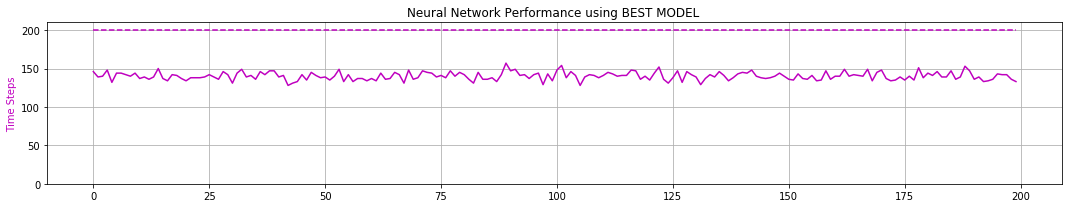

peak memory: 73679.31 MiB, increment: 65142.51 MiB
0 -max- [ 0.140  0.634  0.049  0.692  0.474]
0 -min- [-2.398 -2.730 -0.209 -1.043  0.425]

1 -max- [ 0.147  0.628  0.054  0.913  0.525]
1 -min- [-2.400 -2.781 -0.209 -1.093  0.477]

2 -max- [ 0.162  0.629  0.050  0.820  0.575]
2 -min- [-2.398 -2.895 -0.209 -1.121  0.525]

3 -max- [ 0.145  0.616  0.049  0.800  0.625]
3 -min- [-2.400 -2.985 -0.209 -0.922  0.576]

4 -max- [ 0.135  0.630  0.050  0.691  0.675]
4 -min- [-2.399 -2.926 -0.209 -1.024  0.626]

5 -max- [ 0.143  0.627  0.050  0.885  0.725]
5 -min- [-2.399 -3.107 -0.207 -0.898  0.676]

6 -max- [ 0.132  0.631  0.050  0.869  0.775]
6 -min- [-2.400 -3.117 -0.204 -0.876  0.725]

7 -max- [ 0.152  0.611  0.048  0.688  0.825]
7 -min- [-2.400 -3.141 -0.204 -1.132  0.776]

8 -max- [ 0.157  0.610  0.050  0.915  0.874]
8 -min- [-2.399 -3.271 -0.208 -0.959  0.825]

9 -max- [ 0.161  0.629  0.053  0.736  0.924]
9 -min- [-2.399 -3.165 -0.209 -0.923  0.876]

Quantization TIME:  0.59 minutes


ITER

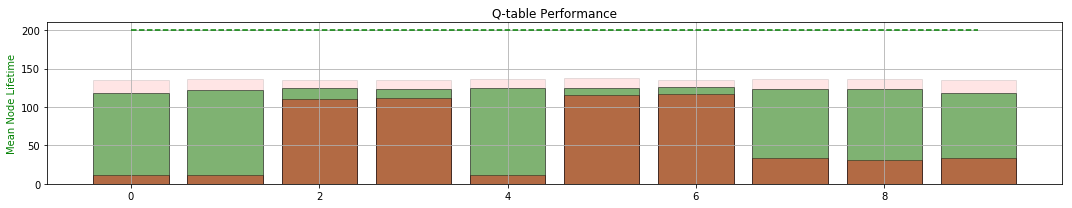

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 106.594	LOSS : 113.554	LOSS : 109.965	LOSS : 115.170	LOSS : 119.844	LOSS : 129.838	LOSS : 142.829	LOSS : 151.330	LOSS : 148.854	LOSS : 146.777	LOSS : 140.102	LOSS : 167.078	LOSS : 140.207	LOSS : 143.092	LOSS : 128.674	LOSS : 169.851	LOSS : 132.772	LOSS : 136.897	LOSS : 111.095	LOSS : 116.598	
Validating... MEAN TIME:  112.38
LOSS : 109.249	LOSS : 155.919	LOSS : 126.393	LOSS : 119.013	LOSS : 151.127	LOSS : 144.475	LOSS : 115.750	LOSS : 127.452	LOSS : 129.535	LOSS : 126.002	LOSS : 127.758	LOSS : 127.085	LOSS : 113.367	LOSS : 136.687	LOSS : 112.218	LOSS : 130.210	LOSS : 120.272	LOSS : 135.394	LOSS : 115.767	LOSS : 123.627	
Validating... MEAN TIME:  110.305
LOSS : 113.799	LOSS : 138.611	LOSS : 118.058	LOSS : 124.497	LOSS : 80.577	LOSS : 117.451	LOSS : 114.980	LOSS : 103.673	LOSS : 148.403	LOSS : 132.511	LOSS : 135.186	LOSS : 121.482	LOSS : 127.368	LOSS : 127.579	LOSS : 107.012	LOSS : 108.341	LOSS : 12

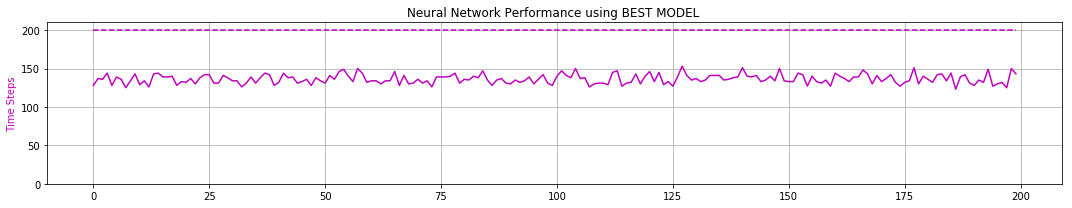

peak memory: 73875.27 MiB, increment: 65339.35 MiB
0 -max- [ 0.195  1.319  0.050  1.009  0.475]
0 -min- [-2.269 -2.430 -0.209 -2.005  0.426]

1 -max- [ 0.226  1.403  0.050  1.000  0.525]
1 -min- [-2.266 -2.435 -0.209 -2.020  0.475]

2 -max- [ 0.194  1.186  0.049  1.197  0.575]
2 -min- [-2.312 -2.635 -0.209 -1.743  0.526]

3 -max- [ 0.181  1.150  0.050  1.236  0.624]
3 -min- [-2.393 -2.654 -0.209 -1.727  0.575]

4 -max- [ 0.201  1.382  0.050  0.968  0.674]
4 -min- [-2.387 -2.441 -0.209 -2.033  0.625]

5 -max- [ 0.155  0.826  0.050  1.188  0.724]
5 -min- [-2.394 -2.641 -0.209 -1.672  0.676]

6 -max- [ 0.147  1.011  0.048  1.202  0.774]
6 -min- [-2.399 -2.636 -0.209 -1.983  0.725]

7 -max- [ 0.152  0.824  0.050  1.122  0.824]
7 -min- [-2.399 -2.636 -0.209 -1.658  0.775]

8 -max- [ 0.147  0.964  0.092  1.541  0.875]
8 -min- [-2.399 -2.971 -0.209 -2.031  0.826]

9 -max- [ 0.139  0.828  0.087  1.245  0.924]
9 -min- [-2.399 -2.996 -0.209 -2.005  0.876]

Quantization TIME:  0.58 minutes


ITER

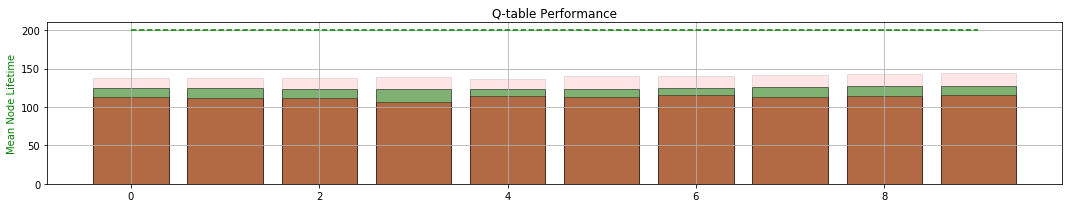

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 126.181	LOSS : 167.167	LOSS : 140.753	LOSS : 185.357	LOSS : 226.337	LOSS : 190.108	LOSS : 230.971	LOSS : 193.299	LOSS : 197.300	LOSS : 237.117	LOSS : 231.250	LOSS : 241.329	LOSS : 224.584	LOSS : 232.377	LOSS : 212.784	LOSS : 258.309	LOSS : 230.513	LOSS : 183.705	LOSS : 195.146	LOSS : 263.762	
Validating... MEAN TIME:  139.145
LOSS : 230.400	LOSS : 227.534	LOSS : 202.058	LOSS : 193.910	LOSS : 232.474	LOSS : 227.002	LOSS : 212.872	LOSS : 189.259	LOSS : 238.990	LOSS : 156.247	LOSS : 228.847	LOSS : 175.802	LOSS : 196.450	LOSS : 164.747	LOSS : 199.131	LOSS : 180.741	LOSS : 185.325	LOSS : 189.400	LOSS : 224.567	LOSS : 175.106	
Validating... MEAN TIME:  149.795
LOSS : 209.714	LOSS : 165.725	LOSS : 178.118	LOSS : 201.052	LOSS : 131.559	LOSS : 144.976	LOSS : 129.755	LOSS : 162.729	LOSS : 170.356	LOSS : 157.313	LOSS : 145.652	LOSS : 148.619	LOSS : 147.805	LOSS : 170.269	LOSS : 127.061	LOSS : 126.371	LOSS : 

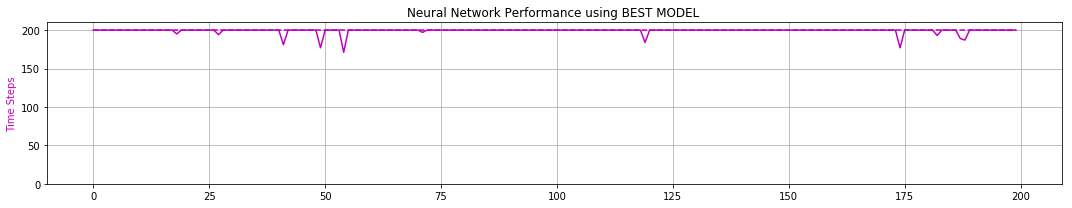

peak memory: 73945.61 MiB, increment: 65483.64 MiB
0 -max- [ 0.146  0.824  0.050  1.059  0.474]
0 -min- [-2.400 -3.150 -0.209 -1.185  0.425]

1 -max- [ 0.138  1.024  0.049  1.083  0.525]
1 -min- [-2.399 -3.157 -0.205 -1.442  0.475]

2 -max- [ 0.124  0.963  0.050  1.037  0.575]
2 -min- [-2.399 -3.147 -0.208 -1.433  0.525]

3 -max- [ 0.128  0.827  0.050  0.973  0.624]
3 -min- [-2.400 -2.981 -0.209 -1.209  0.576]

4 -max- [ 0.124  0.934  0.050  0.994  0.675]
4 -min- [-2.400 -2.967 -0.208 -1.363  0.626]

5 -max- [ 0.134  1.011  0.048  0.893  0.724]
5 -min- [-2.400 -2.808 -0.209 -1.390  0.675]

6 -max- [ 0.139  1.016  0.050  0.954  0.775]
6 -min- [-2.400 -2.910 -0.208 -1.446  0.726]

7 -max- [ 0.144  0.964  0.050  1.002  0.825]
7 -min- [-2.400 -2.789 -0.202 -1.391  0.776]

8 -max- [ 0.120  0.829  0.049  1.095  0.874]
8 -min- [-2.399 -3.004 -0.207 -1.339  0.826]

9 -max- [ 0.113  0.933  0.049  1.133  0.925]
9 -min- [-2.400 -2.793 -0.193 -1.435  0.875]

Quantization TIME:  0.59 minutes


ITER

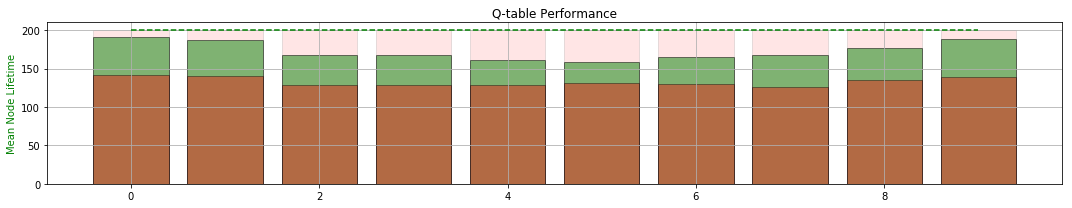

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 94.655	LOSS : 103.916	LOSS : 97.454	LOSS : 116.355	LOSS : 132.604	LOSS : 125.059	LOSS : 115.547	LOSS : 111.781	LOSS : 87.379	LOSS : 111.002	LOSS : 115.834	LOSS : 91.358	LOSS : 96.266	LOSS : 130.052	LOSS : 130.435	LOSS : 129.289	LOSS : 123.012	LOSS : 113.013	LOSS : 126.944	LOSS : 123.832	
Validating... MEAN TIME:  139.09
LOSS : 108.898	LOSS : 138.216	LOSS : 114.613	LOSS : 129.559	LOSS : 117.911	LOSS : 116.356	LOSS : 148.635	LOSS : 122.605	LOSS : 117.801	LOSS : 119.813	LOSS : 142.999	LOSS : 112.025	LOSS : 116.563	LOSS : 106.487	LOSS : 109.697	LOSS : 130.828	LOSS : 102.951	LOSS : 123.063	LOSS : 137.367	LOSS : 147.108	
Validating... MEAN TIME:  185.97
LOSS : 110.905	LOSS : 122.152	LOSS : 119.958	LOSS : 109.599	LOSS : 130.738	LOSS : 109.642	LOSS : 122.098	LOSS : 101.515	LOSS : 115.804	LOSS : 124.377	LOSS : 95.723	LOSS : 92.830	LOSS : 112.758	LOSS : 86.797	LOSS : 104.259	LOSS : 99.950	LOSS : 103.449	LOS

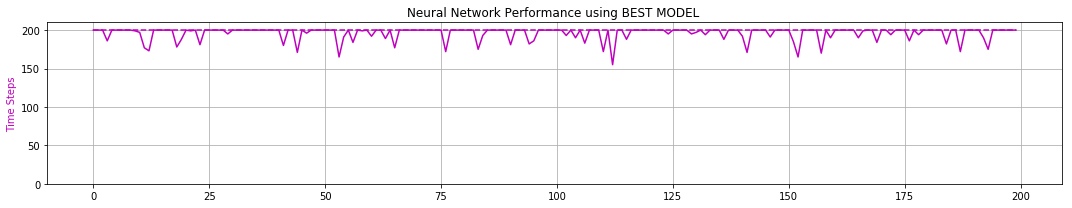

peak memory: 73912.30 MiB, increment: 65398.60 MiB
0 -max- [ 0.186  0.613  0.049  0.707  0.475]
0 -min- [-2.120 -2.053 -0.209 -0.801  0.426]

1 -max- [ 0.244  0.443  0.050  0.934  0.525]
1 -min- [-2.181 -2.237 -0.209 -0.803  0.475]

2 -max- [ 0.179  0.437  0.050  0.709  0.575]
2 -min- [-2.185 -2.235 -0.209 -0.793  0.525]

3 -max- [ 0.154  0.589  0.050  0.698  0.625]
3 -min- [-2.051 -2.232 -0.209 -0.783  0.575]

4 -max- [ 0.175  0.618  0.048  0.710  0.673]
4 -min- [-2.082 -2.222 -0.209 -0.838  0.625]

5 -max- [ 0.189  0.623  0.050  0.708  0.724]
5 -min- [-2.100 -2.369 -0.209 -0.807  0.676]

6 -max- [ 0.666  0.613  0.050  0.730  0.775]
6 -min- [-2.046 -2.382 -0.209 -0.872  0.726]

7 -max- [ 0.828  0.795  0.058  0.970  0.825]
7 -min- [-2.030 -2.235 -0.209 -0.911  0.775]

8 -max- [ 0.793  0.787  0.057  0.719  0.874]
8 -min- [-2.030 -2.215 -0.209 -0.777  0.825]

9 -max- [ 1.275  1.090  0.077  0.708  0.925]
9 -min- [-2.025 -2.226 -0.209 -0.814  0.876]

Quantization TIME:  0.59 minutes


ITER

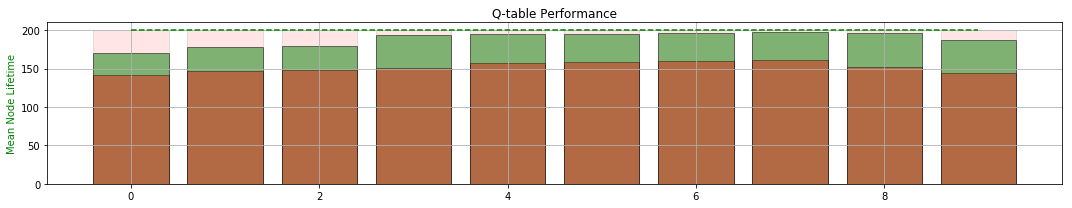

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 194.755	LOSS : 136.462	LOSS : 134.534	LOSS : 119.294	LOSS : 108.031	LOSS : 94.127	LOSS : 108.761	LOSS : 110.980	LOSS : 97.044	LOSS : 100.408	LOSS : 105.583	LOSS : 116.134	LOSS : 94.455	LOSS : 89.932	LOSS : 87.087	LOSS : 87.879	LOSS : 83.159	LOSS : 81.669	LOSS : 85.761	LOSS : 61.049	
Validating... MEAN TIME:  139.405
LOSS : 67.608	LOSS : 70.849	LOSS : 76.200	LOSS : 77.890	LOSS : 82.667	LOSS : 67.220	LOSS : 73.998	LOSS : 84.727	LOSS : 79.380	LOSS : 78.917	LOSS : 69.715	LOSS : 78.578	LOSS : 68.546	LOSS : 66.880	LOSS : 65.796	LOSS : 94.272	LOSS : 86.332	LOSS : 86.967	LOSS : 93.331	LOSS : 93.022	
Validating... MEAN TIME:  143.115
LOSS : 90.257	LOSS : 90.313	LOSS : 88.871	LOSS : 101.749	LOSS : 107.804	LOSS : 111.649	LOSS : 104.609	LOSS : 118.150	LOSS : 95.803	LOSS : 130.575	LOSS : 112.292	LOSS : 98.775	LOSS : 121.113	LOSS : 109.362	LOSS : 147.747	LOSS : 98.988	LOSS : 81.640	LOSS : 82.697	LOSS : 74.629	L

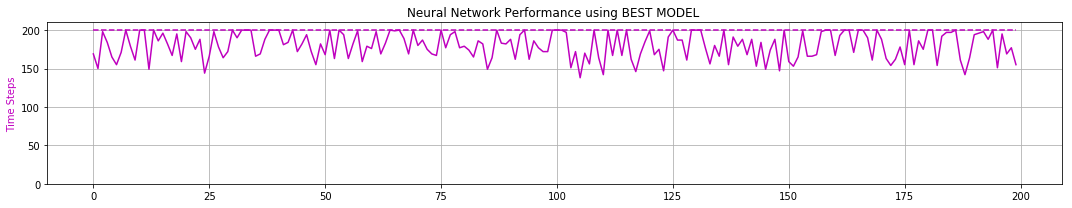

peak memory: 73662.52 MiB, increment: 65156.82 MiB
0 -max- [ 0.108  0.577  0.050  0.743  0.474]
0 -min- [-2.400 -2.605 -0.209 -1.002  0.425]

1 -max- [ 0.113  0.578  0.050  0.664  0.525]
1 -min- [-2.400 -2.608 -0.209 -0.873  0.475]

2 -max- [ 0.195  0.575  0.050  0.827  0.573]
2 -min- [-2.400 -2.610 -0.209 -0.881  0.526]

3 -max- [ 0.236  0.620  0.048  0.874  0.625]
3 -min- [-2.399 -2.569 -0.209 -0.882  0.575]

4 -max- [ 0.562  0.566  0.057  0.846  0.675]
4 -min- [-2.397 -2.421 -0.209 -0.953  0.625]

5 -max- [ 0.559  0.579  0.050  0.709  0.724]
5 -min- [-2.396 -2.359 -0.207 -0.881  0.676]

6 -max- [ 0.320  0.602  0.049  0.750  0.774]
6 -min- [-2.400 -2.245 -0.196 -0.981  0.725]

7 -max- [ 1.453  1.480  0.051  0.892  0.825]
7 -min- [-2.395 -2.199 -0.209 -1.390  0.776]

8 -max- [ 2.345  2.474  0.126  0.933  0.875]
8 -min- [-2.364 -2.234 -0.209 -1.678  0.825]

9 -max- [ 2.400  2.589  0.152  1.335  0.925]
9 -min- [-2.360 -1.662 -0.209 -1.787  0.875]

Quantization TIME:  0.58 minutes


ITER

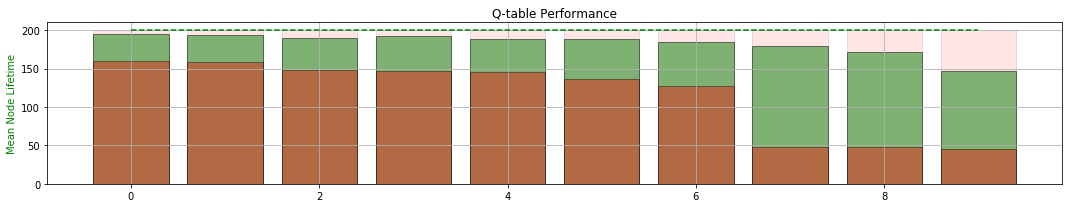

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 71.503	LOSS : 69.441	LOSS : 64.445	LOSS : 57.118	LOSS : 66.878	LOSS : 69.824	LOSS : 66.473	LOSS : 54.077	LOSS : 68.105	LOSS : 60.169	LOSS : 60.432	LOSS : 57.918	LOSS : 56.355	LOSS : 56.898	LOSS : 54.338	LOSS : 57.431	LOSS : 51.289	LOSS : 59.516	LOSS : 57.688	LOSS : 63.989	
Validating... MEAN TIME:  200.0
LOSS : 57.776	LOSS : 59.680	LOSS : 64.965	LOSS : 42.831	LOSS : 59.396	LOSS : 60.819	LOSS : 58.584	LOSS : 45.605	LOSS : 51.561	LOSS : 56.722	LOSS : 50.333	LOSS : 51.946	LOSS : 51.207	LOSS : 51.238	LOSS : 61.170	LOSS : 64.410	LOSS : 62.767	LOSS : 56.807	LOSS : 50.303	LOSS : 62.418	
Validating... MEAN TIME:  187.195
LOSS : 48.257	LOSS : 56.229	LOSS : 54.350	LOSS : 60.862	LOSS : 56.599	LOSS : 56.577	LOSS : 58.024	LOSS : 57.067	LOSS : 65.741	LOSS : 43.376	LOSS : 57.811	LOSS : 49.043	LOSS : 56.794	LOSS : 46.589	LOSS : 49.794	LOSS : 53.926	LOSS : 56.460	LOSS : 60.781	LOSS : 47.429	LOSS : 54.907	
Validati

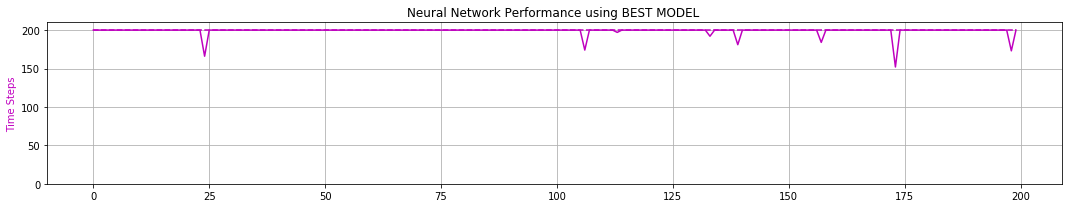

peak memory: 73911.77 MiB, increment: 65370.33 MiB
0 -max- [ 2.399  2.041  0.162  1.446  0.475]
0 -min- [-2.388 -1.833 -0.197 -1.268  0.426]

1 -max- [ 2.399  2.080  0.168  1.531  0.524]
1 -min- [-1.239 -1.276 -0.110 -1.383  0.475]

2 -max- [ 2.400  2.380  0.189  1.523  0.575]
2 -min- [-2.037 -1.699 -0.145 -1.382  0.526]

3 -max- [ 2.399  2.405  0.180  1.572  0.625]
3 -min- [-1.790 -1.834 -0.148 -1.367  0.576]

4 -max- [ 2.400  2.651  0.207  1.518  0.674]
4 -min- [-1.303 -1.428 -0.136 -1.608  0.625]

5 -max- [ 2.396  2.616  0.196  1.450  0.724]
5 -min- [-2.386 -1.703 -0.163 -1.519  0.675]

6 -max- [ 2.400  2.453  0.201  1.656  0.775]
6 -min- [-0.416 -1.257 -0.114 -1.690  0.725]

7 -max- [ 2.400  2.578  0.209  1.882  0.824]
7 -min- [-0.176 -1.283 -0.132 -1.641  0.775]

8 -max- [ 2.399  2.935  0.209  2.036  0.874]
8 -min- [-0.201 -1.020 -0.099 -1.666  0.825]

9 -max- [ 2.399  2.815  0.209  2.174  0.924]
9 -min- [-0.145 -1.140 -0.073 -1.650  0.876]

Quantization TIME:  0.58 minutes


ITER

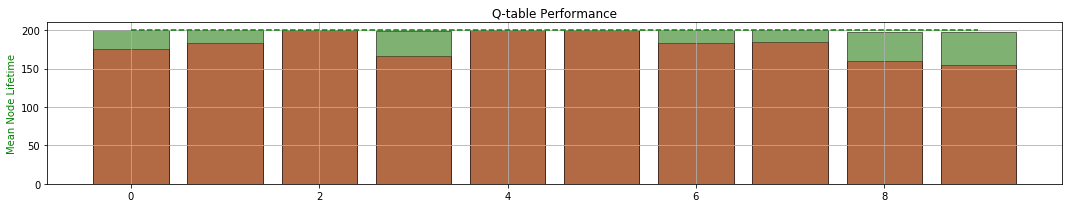

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3750.0
Total Serial Timesteps   :  2863695.0
Speed-up                 :  763.65


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 154  22    3750    2863695     763.65
